# RND (Random Network Distillation)

In this notebook, we will implement an RND algorithm inpired on the paper [Exploration by Random Network Distillation](https://arxiv.org/abs/1810.12894).

The main idea of this algorithm is to use a neural network to predict the features of the observations. The features are the activations of the last hidden layer of a randomly initialized neural network. The loss function is the MSE between the predicted features and the features of the observations. The neural network is updated using the loss function and the observations are stored in a replay buffer. However, in our project, we are not using a RL algorithm, instead we developed a goal-conditioned algorithm. Therefore, we will use the output of the RNDs as a goal selector. The goal selector will be used to select a goal from the goals stored in the Expert demonstrations dataset.

In [1]:
# imports
import os
import robomimic.utils.file_utils as FileUtils
import robomimic.utils.obs_utils as ObsUtils
import helper
import h5py
import numpy as np
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch
import rnd_model

# change this to the path of the project
%cd /project
%load_ext autoreload
%autoreload 2

/project


In [2]:
# Project directory structure
ROOT_DIR = os.getcwd()
WS_DIR = os.path.join(ROOT_DIR, "src/")
DATA_DIR = os.path.join(ROOT_DIR, "data/")
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

In [3]:
## download the dataset
# user parameters
task_0 = "lift"
task_1 = "can"
task_2 = "square"
dataset_type = "ph"
hdf5_type = "low_dim"

# download the dataset
lift_data_path = helper.download_dataset(task_0, dataset_type, hdf5_type, DATA_DIR+task_0)
can_data_path = helper.download_dataset(task_1, dataset_type, hdf5_type, DATA_DIR+task_1)
square_data_path = helper.download_dataset(task_2, dataset_type, hdf5_type, DATA_DIR+task_2)

## Dataloaders

In [4]:
# Aggregate the data from all the demonstrations/trajectories
lift_inputs = rnd_model.aggregate_data(hdf5_path=lift_data_path, task_id=0)
can_inputs = rnd_model.aggregate_data(hdf5_path=can_data_path, task_id=1)
square_inputs = rnd_model.aggregate_data(hdf5_path=square_data_path, task_id=2)

# Create the datasets
dataset_lift = rnd_model.CustomDataset(lift_inputs)
dataset_can = rnd_model.CustomDataset(can_inputs)
dataset_square = rnd_model.CustomDataset(square_inputs)

# Create the dataloaders
batch_size = 128
dataloader_lift = DataLoader(dataset_lift, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
dataloader_can = DataLoader(dataset_can, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
dataloader_square = DataLoader(dataset_square, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)

In [5]:
print(f"lift dataloader length: {len(dataloader_lift)} of batch size: {dataloader_lift.batch_size}")
for batch in dataloader_lift:
    inputs = batch
    print(f"inputs shape: {inputs.shape}")
    break

print(f"can dataloader length: {len(dataloader_can)} of batch size: {dataloader_can.batch_size}")
for batch in dataloader_can:
    inputs = batch
    print(f"inputs shape: {inputs.shape}")
    break

print(f"square dataloader length: {len(dataloader_square)} of batch size: {dataloader_square.batch_size}")
for batch in dataloader_square:
    inputs = batch
    print(f"inputs shape: {inputs.shape}")
    break

lift dataloader length: 76 of batch size: 128
inputs shape: torch.Size([128, 20])
can dataloader length: 182 of batch size: 128
inputs shape: torch.Size([128, 24])
square dataloader length: 236 of batch size: 128
inputs shape: torch.Size([128, 24])


## Model

In [6]:
# check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


In [7]:
## Setting encoders size for the tasks
# task: lift
lift_input_dim = 20 # 19 (state) + 1 (task identifier)
# task: can
can_input_dim = 24 # 23 (state) + 1 (task identifier)
# task: square
square_input_dim = 24 # 23 (state) + 1 (task identifier)
# setting the encoder 
list_of_input_sizes = [lift_input_dim, can_input_dim, square_input_dim]

# setting the model
output_dim = 128  # output dimension of the RND vector of features 
model = rnd_model.RNDModel(list_of_input_sizes, output_dim)

## Training

In [8]:
import itertools
# initialize the optimizer and the loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.MSELoss()

num_epochs = 10

# Create a list of indices for the DataLoaders and create an iterator that cycles through these indices
dataloaders = [dataloader_lift, dataloader_can, dataloader_square]
dataloader_indices = list(range(len(dataloaders)))
map_task_id_to_task_name = {0: "lift", 1: "can", 2: "square"}
dataloaders_cycle = itertools.cycle(dataloader_indices)

# Determine the maximum number of batches among the DataLoaders
max_batches = max(len(dataloader_lift), len(dataloader_can), len(dataloader_square))

# Initialize a list to store the last loss for each task
last_losses = [None] * len(dataloaders)
avg_loss_history = []
lift_loss_history = []
can_loss_history = []
square_loss_history = []

for epoch in range(num_epochs):
    # Reset the iterator for each DataLoader at the start of each epoch
    dataloader_iters = [iter(loader) for loader in dataloaders]
    
    for batch_idx in range(max_batches * len(dataloaders)):
        # Get the next DataLoader index in the cycle
        current_dataloader_idx = next(dataloaders_cycle)
        # Get the next batch from the DataLoader
        current_dataloader_iter = dataloader_iters[current_dataloader_idx]

        try:
            inputs = next(current_dataloader_iter)
        except StopIteration:
            # This DataLoader is exhausted, skip to the next one
            continue
        
        optimizer.zero_grad()
        
        # Forward pass
        target, prediction = model(inputs, current_dataloader_idx)
        
        # Backward pass
        loss = criterion(target, prediction)
        loss.backward()
        optimizer.step()
        
        # Store the loss for the current task
        last_losses[current_dataloader_idx] = loss.item()
        
        # print initial losses for epoch 0
        if epoch == 0 and batch_idx == len(dataloaders) - 1:
            print(f"Initial losses: {last_losses}, avg loss: {np.mean(last_losses)}")
    
    avg_loss_history.append(np.mean(last_losses))
    lift_loss_history.append(last_losses[0])
    can_loss_history.append(last_losses[1])
    square_loss_history.append(last_losses[2])
    print(f"Epoch {epoch+1}, Avg Loss: {np.mean(last_losses):.4f}, ")
    for i, task_loss in enumerate(last_losses):
        print(f"Task {i+1} Last Loss: {task_loss:.4f}")
    

Initial losses: [0.09397942572832108, 0.08475545793771744, 0.09066350013017654], avg loss: 0.08979946126540501
Epoch 1, Avg Loss: 0.0595, 
Task 1 Last Loss: 0.0729
Task 2 Last Loss: 0.0531
Task 3 Last Loss: 0.0525
Epoch 2, Avg Loss: 0.0278, 
Task 1 Last Loss: 0.0368
Task 2 Last Loss: 0.0236
Task 3 Last Loss: 0.0231
Epoch 3, Avg Loss: 0.0107, 
Task 1 Last Loss: 0.0148
Task 2 Last Loss: 0.0088
Task 3 Last Loss: 0.0085
Epoch 4, Avg Loss: 0.0037, 
Task 1 Last Loss: 0.0052
Task 2 Last Loss: 0.0030
Task 3 Last Loss: 0.0029
Epoch 5, Avg Loss: 0.0013, 
Task 1 Last Loss: 0.0018
Task 2 Last Loss: 0.0012
Task 3 Last Loss: 0.0009
Epoch 6, Avg Loss: 0.0005, 
Task 1 Last Loss: 0.0006
Task 2 Last Loss: 0.0005
Task 3 Last Loss: 0.0003
Epoch 7, Avg Loss: 0.0002, 
Task 1 Last Loss: 0.0001
Task 2 Last Loss: 0.0003
Task 3 Last Loss: 0.0001
Epoch 8, Avg Loss: 0.0001, 
Task 1 Last Loss: 0.0001
Task 2 Last Loss: 0.0002
Task 3 Last Loss: 0.0001
Epoch 9, Avg Loss: 0.0001, 
Task 1 Last Loss: 0.0001
Task 2 Last 

In [14]:
torch.save(model.state_dict(), "pretrained_weights/rnd_model.pt")

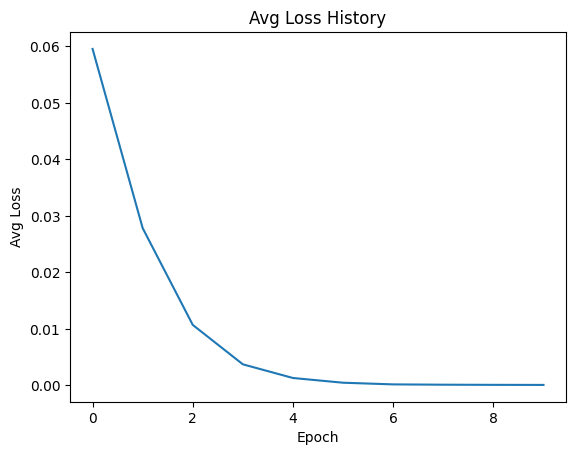

In [9]:
# plot avg loss history
import matplotlib.pyplot as plt
plt.plot(avg_loss_history)
plt.xlabel("Epoch")
plt.ylabel("Avg Loss")
plt.title("Avg Loss History")
plt.show()

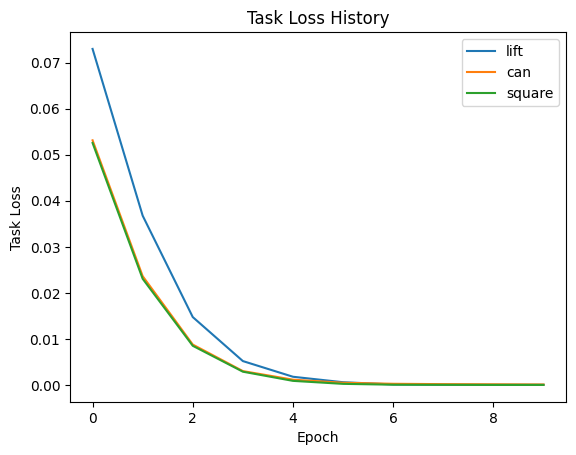

In [10]:
# plot task loss history
plt.plot(lift_loss_history, label="lift")
plt.plot(can_loss_history, label="can")
plt.plot(square_loss_history, label="square")
plt.xlabel("Epoch")
plt.ylabel("Task Loss")
plt.title("Task Loss History")
plt.legend()
plt.show()

## Evaluation

RNDs should show a higher loss when the agent is in a state that is not in the dataset. Therefore, we can use the loss as a measure of the novelty of the state. We can use this measure to select the goals that are more novel to the agent.

In [11]:
# novel states from a new task
task_3 = "transport"
transport_data_path = helper.download_dataset(task_0, dataset_type, hdf5_type, DATA_DIR+task_3)
# Aggregate the data from all the demonstrations/trajectories
transport_inputs = rnd_model.aggregate_data(hdf5_path=transport_data_path, task_id=3)
# Create the datasets
dataset_transport = rnd_model.CustomDataset(transport_inputs)
# Create the dataloaders
batch_size = 128
dataloader_transport = DataLoader(dataset_transport, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
print(f"transport dataloader length: {len(dataloader_transport)} of batch size: {dataloader_transport.batch_size}")
for batch in dataloader_transport:
    inputs = batch
    print(f"inputs shape: {inputs.shape}")
    break

transport dataloader length: 76 of batch size: 128
inputs shape: torch.Size([128, 20])


In [12]:
# evaluate the model

criterion = torch.nn.MSELoss(reduction="none")

model.eval()
with torch.no_grad():
    print("=============== lift dataloader ===============")
    for batch in dataloader_lift:
        inputs = batch
        target, prediction = model(inputs, 0)
        novelty_score_known_states_0 = criterion(target, prediction).mean(dim=1)
        print(f"inputs shape: {inputs.shape}")
        print(f"target shape: {target.shape}")
        print(f"prediction shape: {prediction.shape}")
        print(f"novelty_score shape: {novelty_score_known_states_0.shape}")
        break
    print("=============== can dataloader ===============")
    for batch in dataloader_can:
        inputs = batch
        target, prediction = model(inputs, 1)
        novelty_score_known_states_1 = criterion(target, prediction).mean(dim=1)
        print(f"inputs shape: {inputs.shape}")
        print(f"target shape: {target.shape}")
        print(f"prediction shape: {prediction.shape}")
        print(f"novelty_score shape: {novelty_score_known_states_1.shape}")
        break
    print("=============== square dataloader ===============")
    for batch in dataloader_square:
        inputs = batch
        target, prediction = model(inputs, 2)
        novelty_score_known_states_2 = criterion(target, prediction).mean(dim=1)
        print(f"inputs shape: {inputs.shape}")
        print(f"target shape: {target.shape}")
        print(f"prediction shape: {prediction.shape}")
        print(f"novelty_score shape: {novelty_score_known_states_2.shape}")
        break

    print("=============== transport dataloader new states ===============")
    for batch in dataloader_transport:
        inputs = batch
        target, prediction = model(inputs, 0)
        novelty_score_new_states = criterion(target, prediction).mean(dim=1)
        print(f"inputs shape: {inputs.shape}")
        print(f"target shape: {target.shape}")
        print(f"prediction shape: {prediction.shape}")
        print(f"novelty_score shape: {novelty_score_new_states.shape}")
        break


=============== lift dataloader ===============


inputs shape: torch.Size([128, 20])
target shape: torch.Size([128, 128])
prediction shape: torch.Size([128, 128])
novelty_score shape: torch.Size([128])
=============== can dataloader ===============
inputs shape: torch.Size([128, 24])
target shape: torch.Size([128, 128])
prediction shape: torch.Size([128, 128])
novelty_score shape: torch.Size([128])
=============== square dataloader ===============
inputs shape: torch.Size([128, 24])
target shape: torch.Size([128, 128])
prediction shape: torch.Size([128, 128])
novelty_score shape: torch.Size([128])
=============== transport dataloader new states ===============
inputs shape: torch.Size([128, 20])
target shape: torch.Size([128, 128])
prediction shape: torch.Size([128, 128])
novelty_score shape: torch.Size([128])


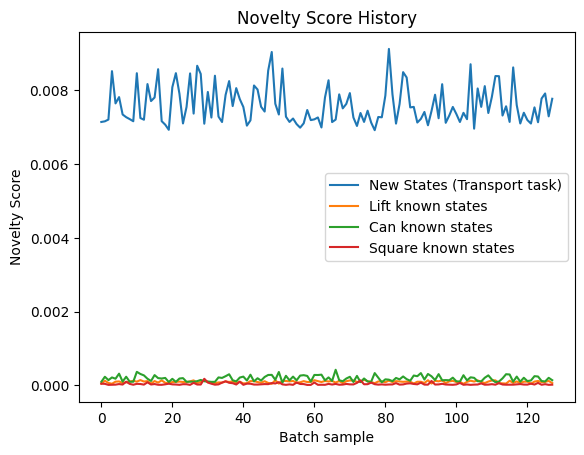

In [20]:
# plot the novelty score
import matplotlib.pyplot as plt
plt.plot(novelty_score_new_states, label="New States (Transport task)")
plt.plot(novelty_score_known_states_0, label="Lift known states")
plt.plot(novelty_score_known_states_1, label="Can known states")
plt.plot(novelty_score_known_states_2, label="Square known states")
plt.xlabel("Batch sample")
plt.ylabel("Novelty Score")
plt.title("Novelty Score History")
plt.legend()
plt.show()

**Conclusion:** As we can see in the plot above, the loss is higher when the agent is in a state that is not in the dataset. Therefore, we can use the loss as a measure of the novelty of the state. We can use this measure to select the goals that are more novel to the agent.